Importing all the libraries necessary for completing this assignment.

In [6]:
!pip install -U -q segmentation-models
!pip install -q tensorflow==2.1
!pip install -q keras==2.3.1

     |████████████████████████████████| 421.8MB 28kB/s 
     |████████████████████████████████| 450kB 46.4MB/s 
     |████████████████████████████████| 3.9MB 43.6MB/s 
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.


In [30]:
import math
from PIL import Image, ImageDraw
from PIL import ImagePath
import pandas as pd
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ["SM_FRAMEWORK"] = "tf.keras"
from tqdm import tqdm
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import imgaug.augmenters as iaa
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau
import segmentation_models as sm
from segmentation_models import Unet
from segmentation_models.metrics import iou_score
tf.keras.backend.set_image_data_format('channels_last')

Extracting the zipped file which contains the images and corresponding mask.

In [2]:
!unzip -x '/content/drive/MyDrive/Segmentation/data.zip'

Streaming output truncated to the last 5000 lines.
  inflating: data/images/377/frame28480_leftImg8bit.jpg  
  inflating: data/images/377/frame28699_leftImg8bit.jpg  
  inflating: data/images/377/frame28808_leftImg8bit.jpg  
  inflating: data/images/377/frame29080_leftImg8bit.jpg  
  inflating: data/images/377/frame29271_leftImg8bit.jpg  
  inflating: data/images/377/frame29435_leftImg8bit.jpg  
  inflating: data/images/377/frame29653_leftImg8bit.jpg  
  inflating: data/images/377/frame29817_leftImg8bit.jpg  
  inflating: data/images/377/frame30062_leftImg8bit.jpg  
  inflating: data/images/377/frame30199_leftImg8bit.jpg  
  inflating: data/images/377/frame3039_leftImg8bit.jpg  
  inflating: data/images/377/frame30417_leftImg8bit.jpg  
  inflating: data/images/377/frame30499_leftImg8bit.jpg  
  inflating: data/images/377/frame30608_leftImg8bit.jpg  
  inflating: data/images/377/frame30744_leftImg8bit.jpg  
  inflating: data/images/377/frame30908_leftImg8bit.jpg  
  inflating: data/imag

It can be observed that the images and their corresponding mask are stored in two separate folders. The masking objects present in each scene is represented in the form of a json file. The directory tree is shown below — 


<pre>
|--- data
|-----| ---- images
|-----| ------|----- Scene 1
|-----| ------|--------| ----- Frame 1 (image 1)
|-----| ------|--------| ----- Frame 2 (image 2)
|-----| ------|--------| ----- ...
|-----| ------|----- Scene 2
|-----| ------|--------| ----- Frame 1 (image 1)
|-----| ------|--------| ----- Frame 2 (image 2)
|-----| ------|--------| ----- ...
|-----| ------|----- .....
|-----| ---- masks
|-----| ------|----- Scene 1
|-----| ------|--------| ----- json 1 (labeled objects in image 1)
|-----| ------|--------| ----- json 2 (labeled objects in image 1)
|-----| ------|--------| ----- ...
|-----| ------|----- Scene 2
|-----| ------|--------| ----- json 1 (labeled objects in image 1)
|-----| ------|--------| ----- json 2 (labeled objects in image 1)
|-----| ------|--------| ----- ...
|-----| ------|----- .....
</pre>

We shall now create a dataframe containing the image of each scene and the corresponding masking object. There are a total of 4008 images present in this dataset.

In [3]:
images = [os.path.join(root[9:],file1) for root, dirs, files in os.walk('/content/data/images') for file1 in files]
json = [os.path.join(root[9:],file1) for root, dirs, files in os.walk('/content/data/mask') for file1 in files]

In [4]:
data_df = pd.DataFrame({'image':sorted(images),'json':sorted(json)})
data_df

,image,json
0,data/images/201/frame0029_leftImg8bit.jpg,data/mask/201/frame0029_gtFine_polygons.json
1,data/images/201/frame0299_leftImg8bit.jpg,data/mask/201/frame0299_gtFine_polygons.json
2,data/images/201/frame0779_leftImg8bit.jpg,data/mask/201/frame0779_gtFine_polygons.json
3,data/images/201/frame1019_leftImg8bit.jpg,data/mask/201/frame1019_gtFine_polygons.json
4,data/images/201/frame1469_leftImg8bit.jpg,data/mask/201/frame1469_gtFine_polygons.json
...,...,...
4003,data/images/429/frame13262_leftImg8bit.jpg,data/mask/429/frame13262_gtFine_polygons.json
4004,data/images/429/frame13699_leftImg8bit.jpg,data/mask/429/frame13699_gtFine_polygons.json
4005,data/images/429/frame15812_leftImg8bit.jpg,data/mask/429/frame15812_gtFine_polygons.json
4006,data/images/429/frame18062_leftImg8bit.jpg,data/mask/429/frame18062_gtFine_polygons.json


Each json file contains three attributes— imgHeight, imgWidth and objects. The first two attributes are integers and they represent the width and height of the image. The last attribute is a list which of dictionaries. Each dictionary represents an individual object. The label key represents the type of the object and the polygon key represents the coordinates.

In [5]:
import json
json.loads(open('/content/'+data_df['json'][0]).read())

{'imgHeight': 1080,
 'imgWidth': 1920,
 'objects': [{'date': '14-Jun-2019 17:26:53',
   'deleted': 0,
   'draw': True,
   'id': 0,
   'label': 'road',
   'polygon': [[1094.3204419889503, 572.817679558011],
    [1372.375690607735, 553.7237569060774],
    [1919.0, 699.2307692307692],
    [1919.0, 708.4615384615385],
    [1919.0, 714.2307692307692],
    [1919.0, 703.8461538461538],
    [1919.0, 1079.0],
    [0.0, 1079.0],
    [0.0, 759.2307692307692],
    [999.2307692307692, 572.3076923076923],
    [1084.7734806629835, 572.817679558011],
    [1089.546961325967, 575.2044198895028],
    [1089.546961325967, 575.2044198895028],
    [1090.7403314917128, 575.2044198895028],
    [1090.7403314917128, 575.2044198895028],
    [1101.4806629834254, 572.817679558011],
    [1101.4806629834254, 572.817679558011]],
   'user': 'cvit',
   'verified': 0},
  {'date': '08-Jul-2019 11:36:05',
   'deleted': 0,
   'draw': True,
   'id': 1,
   'label': 'drivable fallback',
   'polygon': [[1168.3093922651935, 584.

Writing a function to drrive all the unique object names.

In [6]:
def return_unique_labels(data_df):
    '''
    This function is used to print all the uniques present in the json objects.
    '''
    all_labels = []
    for i in tqdm(range(len(data_df)), position=0):
      all_labels.extend([j['label'] for j in json.loads(open('/content/'+data_df['json'][i]).read())['objects']])
    unique_labels = set(all_labels)
    return unique_labels

unique_labels = return_unique_labels(data_df)    
print('\nLabels:')
unique_labels

100%|██████████| 4008/4008 [00:51<00:00, 77.41it/s] 



Labels:


{'animal',
 'autorickshaw',
 'bicycle',
 'billboard',
 'bridge',
 'building',
 'bus',
 'car',
 'caravan',
 'curb',
 'drivable fallback',
 'ego vehicle',
 'fallback background',
 'fence',
 'ground',
 'guard rail',
 'motorcycle',
 'non-drivable fallback',
 'obs-str-bar-fallback',
 'out of roi',
 'parking',
 'person',
 'pole',
 'polegroup',
 'rail track',
 'rectification border',
 'rider',
 'road',
 'sidewalk',
 'sky',
 'traffic light',
 'traffic sign',
 'trailer',
 'train',
 'truck',
 'tunnel',
 'unlabeled',
 'vegetation',
 'vehicle fallback',
 'wall'}

We need not assign different levels of brightness to each object. Similar objects can be clubbed together. That is why we are manually defining all the objects which can be clubbed together.

In [7]:
print('Unique labels: ',len(unique_labels))
label_clr = {'road':10, 'parking':20, 'drivable fallback':20,'sidewalk':30,'non-drivable fallback':40,'rail track':40,\
                        'person':50, 'animal':50, 'rider':60, 'motorcycle':70, 'bicycle':70, 'autorickshaw':80,\
                        'car':80, 'truck':90, 'bus':90, 'vehicle fallback':90, 'trailer':90, 'caravan':90,\
                        'curb':100, 'wall':100, 'fence':110,'guard rail':110, 'billboard':120,'traffic sign':120,\
                        'traffic light':120, 'pole':130, 'polegroup':130, 'obs-str-bar-fallback':130,'building':140,\
                        'bridge':140,'tunnel':140, 'vegetation':150, 'sky':160, 'fallback background':160,'unlabeled':0,\
                        'out of roi':0, 'ego vehicle':170, 'ground':180,'rectification border':190,\
                   'train':200}
print('Keys derived from these labels: ',len(label_clr.keys()))
CLASSES_ = list(set(label_clr.values()))
print('Set of unique values: ',*CLASSES_)

Unique labels:  40
Keys derived from these labels:  40
Set of unique values:  0 130 10 140 20 150 30 160 40 170 50 180 60 190 70 200 80 90 100 110 120


In [8]:
def get_poly(file):
  '''
  This function extracts the coordinates of all the objects in
  the image along with the image width and height.
  '''
  data = json.loads(open('/content/'+file).read())
  label = [i['label'] for i in data['objects']]
  vertexlist = []
  for i in data['objects']:
    if len(i['polygon'])>1:
      vertexlist.append([(x,y) for x,y in i['polygon']])
  w = data['imgWidth']
  h = data['imgHeight']
  return w, h, label, list(filter(None,vertexlist))

In [11]:
def compute_masks(data_df):
    '''
    This function is used to add the objects to the first channel 
    of each corresponding image. The masked image is then added
    added to the dataframe.
    '''
    mask_paths = []
    for i in tqdm(range(len(data_df)), position=0):
      w, h, label, vertexlist = get_poly(data_df['json'].values[i])
      img = Image.new("RGB", (w, h))
      img1 = ImageDraw.Draw(img)

      for k in range(len(vertexlist)):
        img1.polygon(vertexlist[k], fill = label_clr[label[k]])
      img = np.array(img)
      im = Image.fromarray(img[:,:,0])
      now_path = '/content/data/output'+data_df['json'].values[i][9:-5]+".png"

      if not os.path.exists(now_path[:24]):
        os.makedirs(now_path[:24])
      im.save(now_path)   
      mask_paths.append(now_path[9:])

    data_df['mask'] = mask_paths
    return data_df

It is now time to extract the objects from the json file and apply it on the raw image. This gives us images with objects drawn in its first channel.

In [12]:
data_df = compute_masks(data_df)
data_df.head()

100%|██████████| 4008/4008 [04:29<00:00, 14.89it/s]


,image,json,mask
0,data/images/201/frame0029_leftImg8bit.jpg,data/mask/201/frame0029_gtFine_polygons.json,data/output/201/frame0029_gtFine_polygons.png
1,data/images/201/frame0299_leftImg8bit.jpg,data/mask/201/frame0299_gtFine_polygons.json,data/output/201/frame0299_gtFine_polygons.png
2,data/images/201/frame0779_leftImg8bit.jpg,data/mask/201/frame0779_gtFine_polygons.json,data/output/201/frame0779_gtFine_polygons.png
3,data/images/201/frame1019_leftImg8bit.jpg,data/mask/201/frame1019_gtFine_polygons.json,data/output/201/frame1019_gtFine_polygons.png
4,data/images/201/frame1469_leftImg8bit.jpg,data/mask/201/frame1469_gtFine_polygons.json,data/output/201/frame1469_gtFine_polygons.png


<pre>
Convolutional neural networks are widely used for image processing tasks.<br> For semantic segmentation, we shall be using an architecture of CNNs known as Unet.<br> Given below is the diagram of this architecture — 
<img src='https://i.imgur.com/rD4yP7J.jpg' width="500"> 
</pre>

Let us split our data sets into train and test sets.

In [13]:
X_train, X_test = train_test_split(data_df, test_size=0.1, random_state=42)

We can artificially expand the size of our train set using image augmentation. The augmentations used here are- horizonal/vertical flip, embossing the image and then marking the images which have a direction and turning them into black and white. 

In [17]:
aug2 = iaa.Fliplr()
aug3 = iaa.Flipud()
aug4 = iaa.Emboss(alpha=(1), strength=1)
aug5 = iaa.DirectedEdgeDetect(alpha=(0.8), direction=(1.0))

This project is dedicated to covering the concept of transfer learning. That's why we shall use Resnet, another architecture of the CNN as our pre-trained base model. The Resnet based model concists of 34 layers and was earlier trained on the Imagenet dataset. Note that we have 21 distinct set of brightness values for all the objects present in our image. The Unet model architecture is also presented below.

In [19]:
model = Unet('resnet34', encoder_weights='imagenet', classes=21, activation='softmax', input_shape=(256,256,3), encoder_freeze=True)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 256, 256, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_34 (ZeroPadding2 (None, 262, 262, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 128, 128, 64) 9408        zero_padding2d_34[0][0]          
____________________________________________________________________________________________

We need to create a custom dataset using are aforementioned augmentations. This cas be done using the Dataset class. 

In [20]:
class Dataset:

    def __init__(self, file_names, value):
        
        self.ids = file_names
        self.images_fps   = [image_id for image_id in self.ids['image']]
        self.masks_fps    = [mask_id for mask_id in self.ids['mask']]
        self.class_values = CLASSES_
        self.boolval = value
    
    def __getitem__(self, i):
        
        image = cv2.imread(self.images_fps[i], cv2.IMREAD_UNCHANGED) 
        image = cv2.resize(image,(256,256),interpolation=cv2.INTER_AREA)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask  = cv2.resize(cv2.imread(self.masks_fps[i], cv2.IMREAD_UNCHANGED),(256,256))
        image_mask = mask

        image_masks = [(image_mask == v) for v in self.class_values]
        image_mask = np.stack(image_masks, axis=-1).astype('float')

        if self.boolval == True:
          a = np.random.uniform()
          if a<0.25:
              image = aug2.augment_image(image)
              image_mask = aug2.augment_image(image_mask)
          elif a<0.5:
              image = aug3.augment_image(image)
              image_mask = aug3.augment_image(image_mask)
          elif a<0.75:
              image = aug4.augment_image(image)
              image_mask = aug4.augment_image(image_mask)
          else:
              image = aug5.augment_image(image)
              image_mask = image_mask
            
        return image, image_mask
        
    def __len__(self):

        return len(self.ids)

Our dataset is hige, and it cannot be directly loaded onto the main memory due to size constraints. That's why we'll convert our dataset into dataset into a generator and club multiple points into batches. The Dataloader class helps us wth this task.

In [ ]:
class Dataloder(tf.keras.utils.Sequence):    

    def __init__(self, dataset, batch_size=3, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size

        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        return tuple(batch)
    
    def __len__(self):

        return len(self.indexes)//self.batch_size
    
    def on_epoch_end(self):

        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

We are using Adam as the optimizer and the loss function used in semantic segmentation is generally dice loss since it performs better than cross entropy.

In [23]:
optim = Adam(0.0001)
loss = sm.losses.cce_dice_loss
model.compile(optim, loss, metrics=[iou_score])

We need to write a condition which terminates the training process upon crossing a baseline condition. This can be done using a custom callback.

In [28]:
class TerminateOnBaseline(Callback):
    """Callback that terminates training when either the iou score
       or validation iou score reaches a specified baseline.
    """
    def __init__(self, monitor='accuracy', baseline=0.40):
        super(TerminateOnBaseline, self).__init__()
        self.monitor = monitor
        self.baseline = baseline
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        acc = logs.get(self.monitor)
        if acc is not None:
            if acc >= self.baseline:
                print('Epoch {}: Baseline has been reached; terminating training.'.format(epoch))
                self.model.stop_training = True

In [ ]:
os.environ['PYTHONHASHSEED'] = '0'
tf.keras.backend.clear_session()
np.random.seed(0)

CLASSES = CLASSES_
train_dataset = Dataset(X_train,True)
test_dataset  = Dataset(X_test,False)

train_dataloader = Dataloder(train_dataset, batch_size=8, shuffle=True)
test_dataloader = Dataloder(test_dataset, batch_size=8, shuffle=True)

callbacks_ = [
    ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min', monitor='val_iou_score'),
    TerminateOnBaseline(monitor='val_iou_score', baseline=0.50),        
    ReduceLROnPlateau(monitor='val_iou_score', min_lr=0.000001,patience=3),
]

We shall now be training the model.

In [ ]:
history = model.fit(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=25,validation_data=test_dataloader,callbacks=callbacks_ )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 450 steps, validate for 50 steps
Epoch 1/25
450/450 [==============================] - 293s 650ms/step - loss: 0.8753 - iou_score: 0.1292 - val_loss: 0.8169 - val_iou_score: 0.1680
Epoch 2/25
450/450 [==============================] - 292s 649ms/step - loss: 0.7638 - iou_score: 0.2082 - val_loss: 0.7327 - val_iou_score: 0.2318
Epoch 3/25
450/450 [==============================] - 288s 641ms/step - loss: 0.6918 - iou_score: 0.2632 - val_loss: 0.6807 - val_iou_score: 0.2745
Epoch 4/25
450/450 [==============================] - 288s 641ms/step - loss: 0.6428 - iou_score: 0.3017 - val_loss: 0.6368 - val_iou_score: 0.3093
Epoch 5/25
450/450 [==============================] - 289s 642ms/step - loss: 0.6046 - iou_score: 0.3333 - val_loss: 0.6223 - val_iou_score: 0.3211
Epoch 6/25
450/450 [==============================] - 290s 644ms/step - loss: 0.5965 - iou_score: 0.3400 - val_loss: 0.6189 - val_iou_score: 0.3244
Epoch 7/25
450/450 

Now it is time to plot the loss and iou score for the train and the test set which we obtained at the end of each epoch.

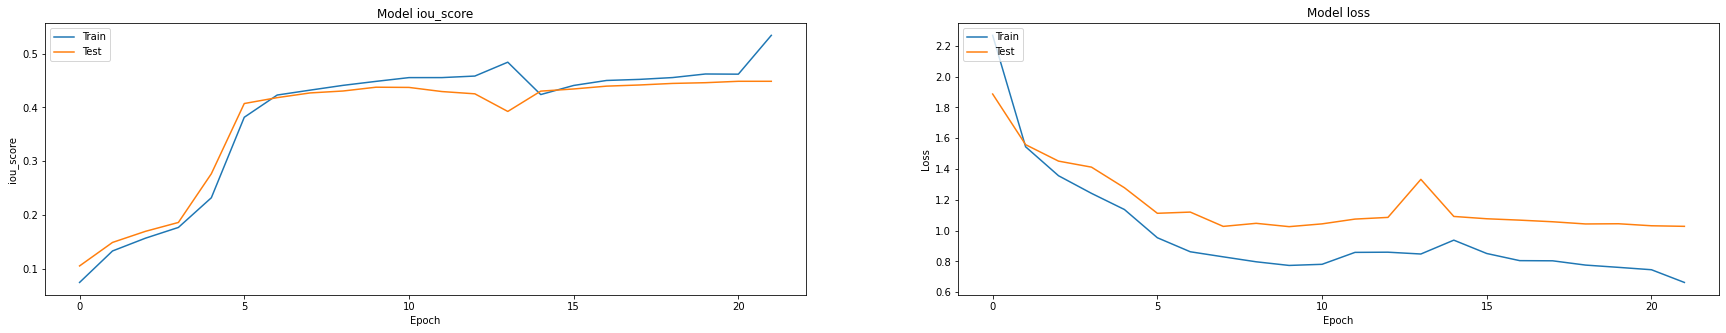

In [ ]:
plt.figure(figsize=(30, 5))

plt.subplot(121)
iou_score_lst = history.history['iou_score']
val_iou_score_lst = history.history['val_iou_score']
plt.plot([i for i in iou_score_lst])
plt.plot([i for i in val_iou_score_lst])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(122)
loss_lst = history.history['loss']
val_loss_lst = history.history['val_loss']
plt.plot([j for j in loss_lst])
plt.plot([j for j in val_loss_lst])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

The performace of the model can be visualized by plotting the model prediction on some values from the test set.

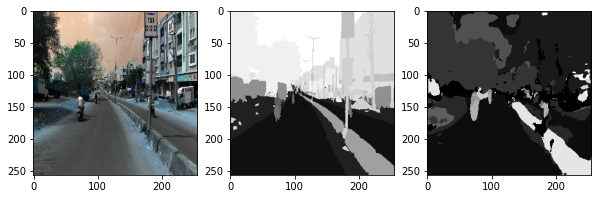

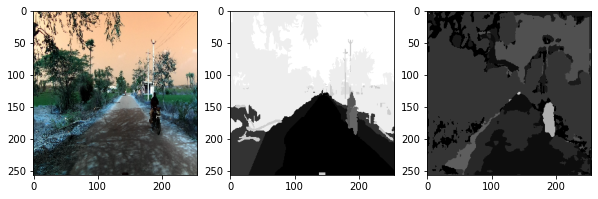

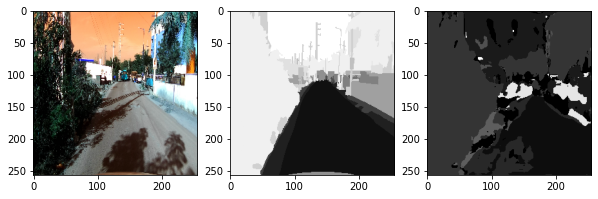

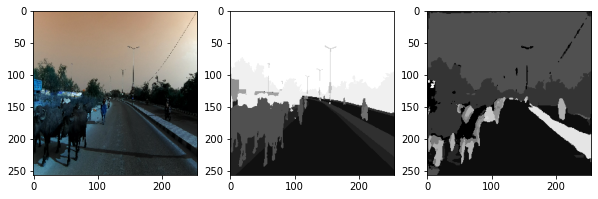

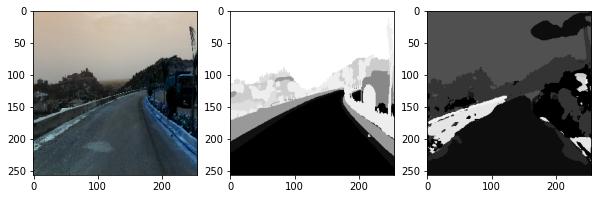

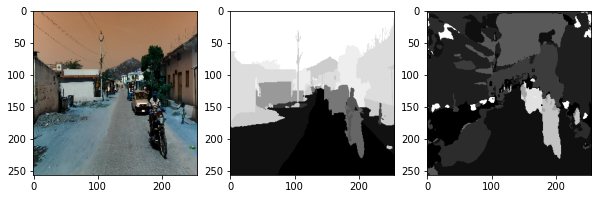

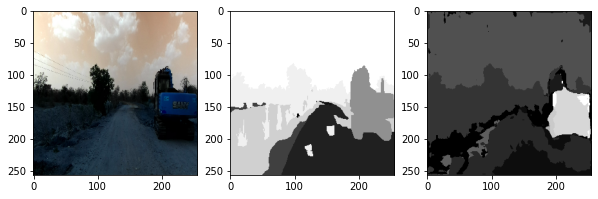

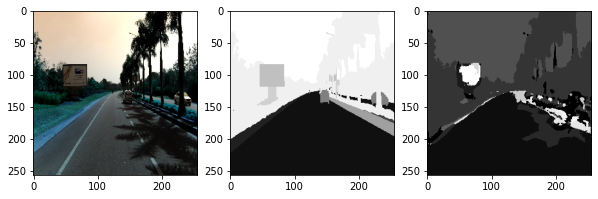

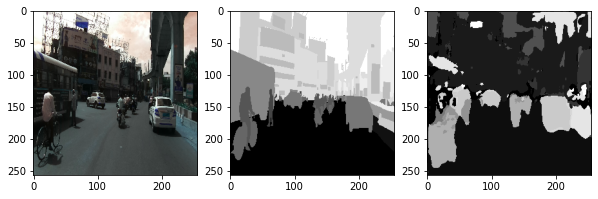

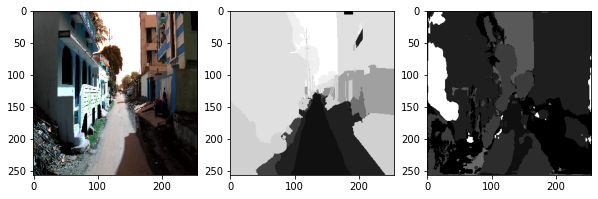

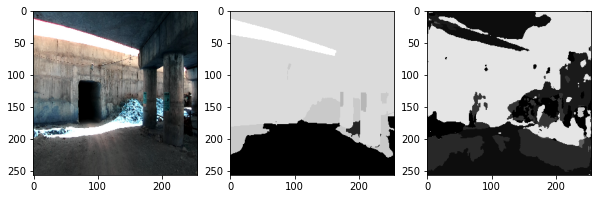

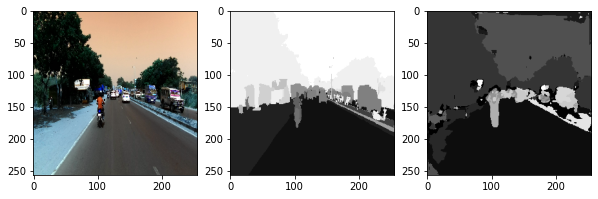

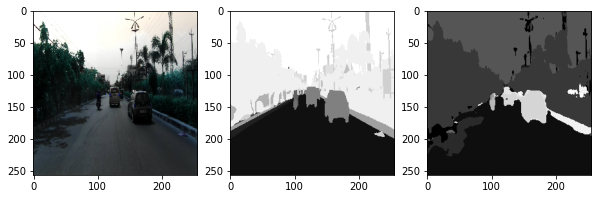

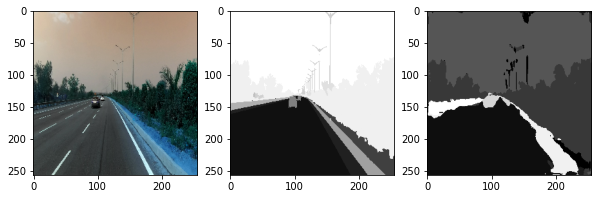

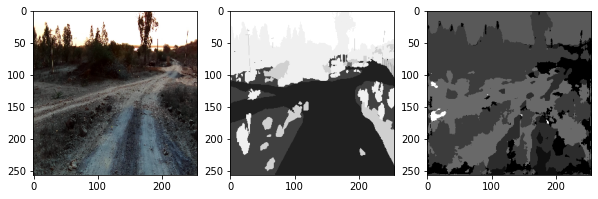

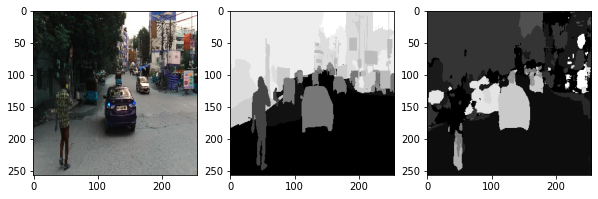

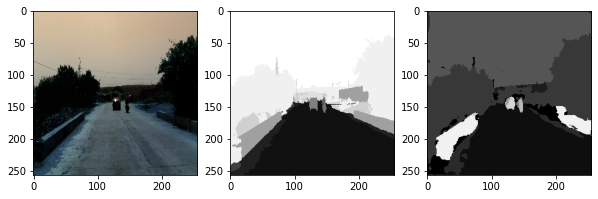

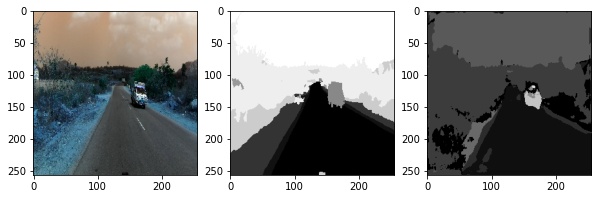

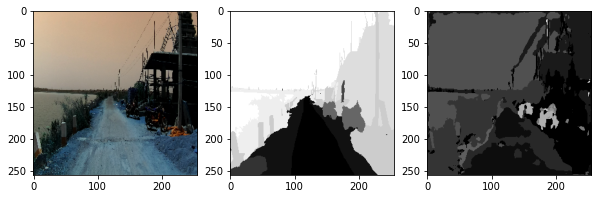

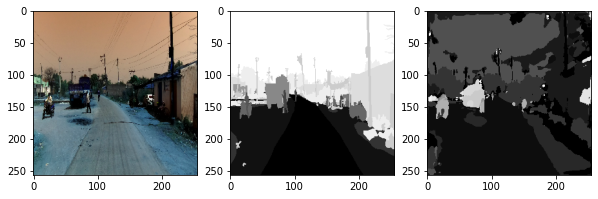

In [ ]:
for p, i in enumerate(range(len(X_test[:20]))):

  image = cv2.imread(list(X_test['image'])[p], cv2.IMREAD_UNCHANGED)
  image = cv2.resize(image, (256,256),interpolation = cv2.INTER_NEAREST) 

  pred_mask  = model.predict(image[np.newaxis,:,:,:])
  pred_mask = tf.argmax(pred_mask, axis=-1)
  image_mask = cv2.imread(list(X_test['mask'])[p], cv2.IMREAD_UNCHANGED)
  image_mask = cv2.resize(image_mask, (256,256),interpolation = cv2.INTER_NEAREST)

  plt.figure(figsize=(10,6))
  plt.subplot(131)
  plt.imshow(image)
  plt.subplot(132)
  plt.imshow(image_mask, cmap='gray')
  plt.subplot(133)
  plt.imshow(pred_mask[0], cmap='gray')

plt.show()

<h2>Reference:</h2>
https://www.geeksforgeeks.org/image-resizing-using-opencv-python/<br>
https://stackoverflow.com/a/53501868<br>
https://dzlab.github.io/dltips/en/keras/data-generator/<br>
https://medium.com/ai-salon/understanding-dice-loss-for-crisp-boundary-detection-bb30c2e5f62b<br>
https://www.geeksforgeeks.org/read-json-file-using-python/
https://stackoverflow.com/a/67708260
